# Импорт библиотек

In [1]:
from __future__ import annotations

from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 5)

from rohlik.config import Config
from rohlik.data import load_raw_data, prepare_frame
from rohlik.metrics import wmae

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")


# Загрузка и просмотр данных

In [2]:
cfg = Config()

raw = load_raw_data(cfg.data_dir)

train = prepare_frame(raw.train, calendar=raw.calendar, inventory=raw.inventory, weights=raw.weights)
test = prepare_frame(raw.test, calendar=raw.calendar, inventory=raw.inventory, weights=None)

print("train:", train.shape, "| test:", test.shape)
print("train date:", train["date"].min().date(), "..", train["date"].max().date())
print("test  date:", test["date"].min().date(), "..", test["date"].max().date())

train.head()


train: (4007419, 44) | test: (47021, 41)
train date: 2020-08-01 .. 2024-06-02
test  date: 2024-06-03 .. 2024-06-16


,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount,weight,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,year,month,day,dayofweek,is_weekend,dow_sin,dow_cos,month_sin,month_cos,discount_max,discount_min,has_discount,has_negative_discount,discount_sum_clipped,discount_mean_clipped,discount_std_clipped,discount_nonzero_cnt,log1p_sell_price_main
0,4845,2024-03-10,Budapest_1,"6,436.0000",16.3400,646.2600,1.0000,0.0000,0.0000,0.0000,0.0000,0.1531,0.0000,0.0000,1.9256,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,NONE,0,0,0,0,2024,3,10,6,1,-0.7818,0.6235,1.0000,0.0000,0.1531,0.0000,1,0,0.1531,0.0219,0.0579,1,6.4727
1,4845,2021-05-25,Budapest_1,"4,663.0000",12.6300,455.9600,1.0000,0.0000,0.0000,0.0000,0.0000,0.1503,0.0000,0.0000,1.9256,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,NONE,0,0,0,0,2021,5,25,1,0,0.7818,0.6235,0.5000,-0.8660,0.1503,0.0000,1,0,0.1503,0.0215,0.0568,1,6.1246
2,4845,2021-12-20,Budapest_1,"6,507.0000",34.5500,455.9600,1.0000,0.0000,0.0000,0.0000,0.0000,0.1503,0.0000,0.0000,1.9256,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,NONE,0,0,0,0,2021,12,20,0,0,0.0000,1.0000,-0.0000,1.0000,0.1503,0.0000,1,0,0.1503,0.0215,0.0568,1,6.1246
3,4845,2023-04-29,Budapest_1,"5,463.0000",34.5200,646.2600,0.9600,0.2002,0.0000,0.0000,0.0000,0.1531,0.0000,0.0000,1.9256,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,NONE,0,0,0,0,2023,4,29,5,1,-0.9749,-0.2225,0.8660,-0.5000,0.2002,0.0000,1,0,0.3534,0.0505,0.0873,2,6.4727
4,4845,2022-04-01,Budapest_1,"5,997.0000",35.9200,486.4100,1.0000,0.0000,0.0000,0.0000,0.0000,0.1565,0.0000,0.0000,1.9256,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,NONE,0,0,0,0,2022,4,1,4,0,-0.4339,-0.9010,0.8660,-0.5000,0.1565,0.0000,1,0,0.1565,0.0224,0.0591,1,6.1891


# Анализ целевой переменной `sales`

In [3]:
# содержит NaN
print(train['sales'].isna().sum(), "строки NaN")
train_clean = train.dropna(subset=["sales"]).copy()

52 строки NaN


### Общая статистика 

In [4]:
print("rows:", len(train_clean))
print("sales min/max:", float(train_clean["sales"].min()), float(train_clean["sales"].max()))
print("sales mean:", float(train_clean["sales"].mean()))
print("pct zero:", float((train_clean["sales"] == 0).mean()))
print("pct zero:", float((train_clean["sales"] < 0).mean()))


rows: 4007367
sales min/max: 0.0 26316.189453125
sales mean: 108.3807601928711
pct zero: 0.012279134903291862
pct zero: 0.0


### В дальнейшем будем работать с небольшим семплом, чтобы гистрограммы нормально считались

In [5]:
sample = train_clean.sample(n=min(cfg.eda_sample_rows, len(train_clean)), random_state=cfg.random_state)
sales = sample["sales"]

### Продажи часто имеют лог-нормальную природу (что и подтверждается в датасете)

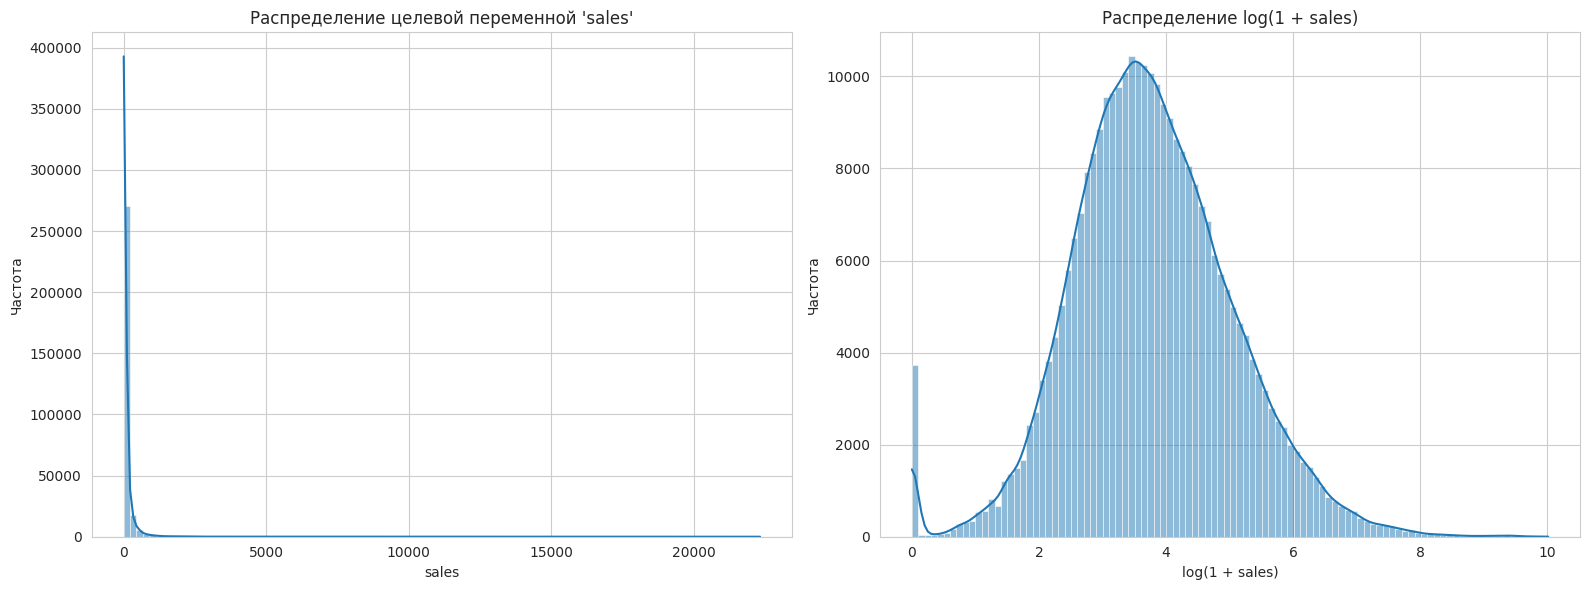

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(sales, bins=100, kde=True, ax=axs[0])
axs[0].set_title("Распределение целевой переменной 'sales'")
axs[0].set_xlabel("sales")
axs[0].set_ylabel("Частота")
axs[0].grid(True)

sns.histplot(np.log1p(sales[sales >= 0]), bins=100, kde=True, ax=axs[1])
axs[1].set_title("Распределение log(1 + sales)")
axs[1].set_xlabel("log(1 + sales)")
axs[1].set_ylabel("Частота")
axs[1].grid(True)

plt.tight_layout()
plt.show()

### Сильного дрифта абсолютных значений не видно

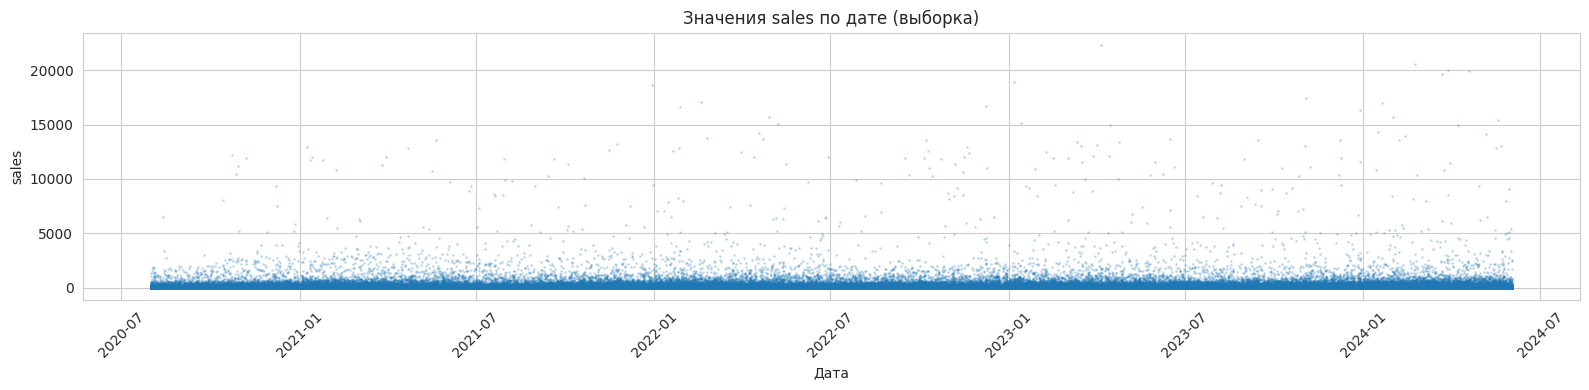

In [7]:
plt.figure(figsize=(16, 4))
sample_sorted = sample.sort_values("date")
plt.plot(sample_sorted["date"], sample_sorted["sales"], '.', alpha=0.2, markersize=2)
plt.title("Значения sales по дате (выборка)")
plt.xlabel("Дата")
plt.ylabel("sales")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


### Скользящие средние выглядят более интересно

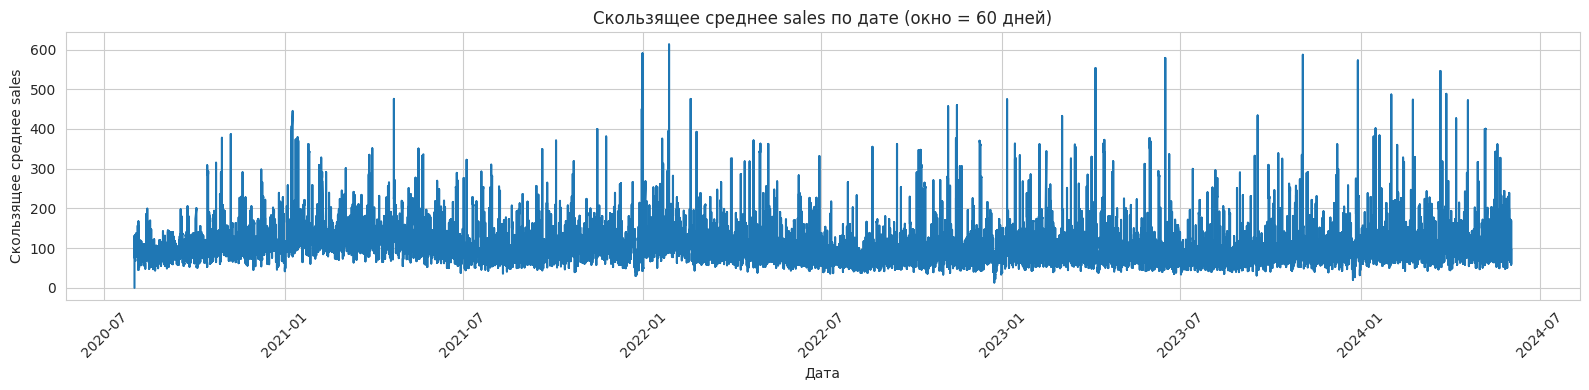

In [8]:
plt.figure(figsize=(16, 4))
sample_sorted["sales_rolling_mean"] = sample_sorted["sales"].rolling(window=60, min_periods=1).mean()
plt.plot(sample_sorted["date"], sample_sorted["sales_rolling_mean"])
plt.title("Скользящее среднее sales по дате (окно = 60 дней)")
plt.xlabel("Дата")
plt.ylabel("Скользящее среднее sales")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### При детальном просмотре отдельных uid лучше виден тренд и сезонность

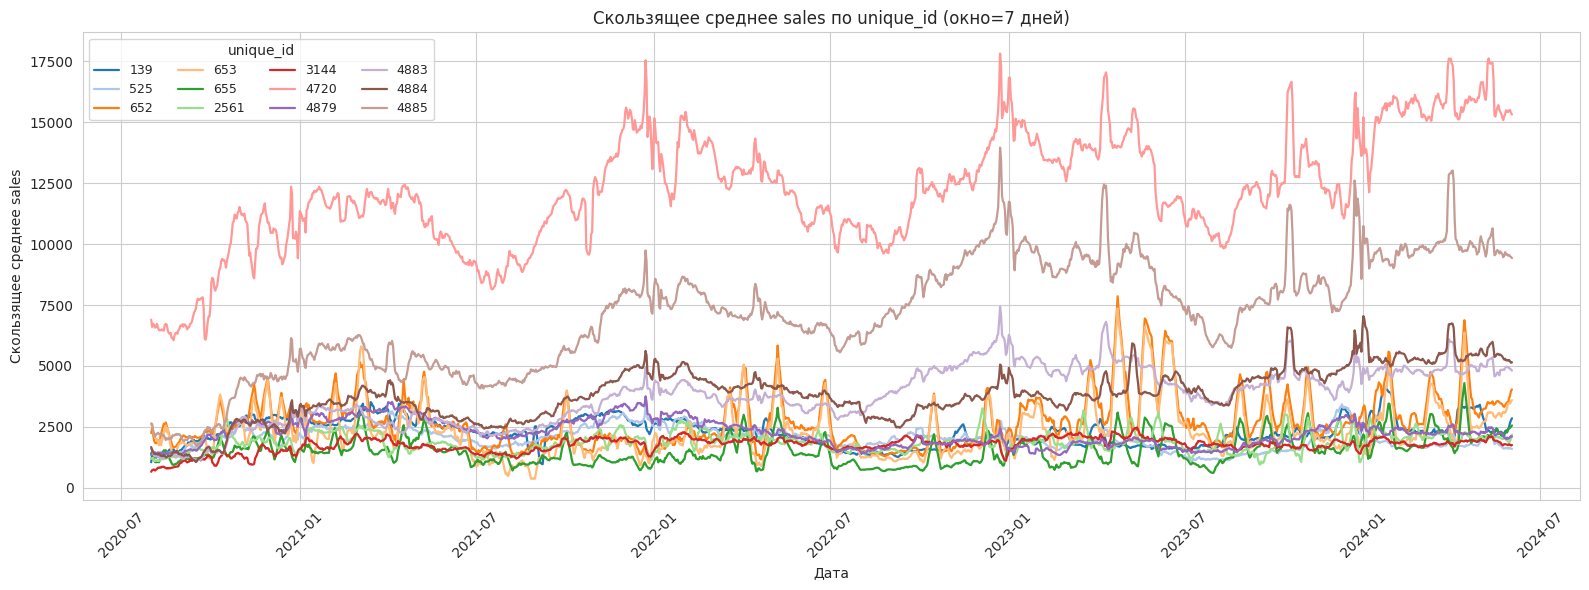

In [9]:
ROLLING_WINDOW_DAYS = 7
TOP_N_UIDS = 12

uid_rank = train_clean.groupby("unique_id", observed=True)["sales"].sum().sort_values(ascending=False)
top_uids = uid_rank.head(TOP_N_UIDS).index.to_list()
win = train_clean[train_clean["unique_id"].isin(top_uids)].copy()

date_range = pd.date_range(start=win['date'].min(), end=win['date'].max(), freq="D")
grid = pd.MultiIndex.from_product([top_uids, date_range], names=["unique_id", "date"]).to_frame(index=False)

dense = grid.merge(win, on=["unique_id", "date"], how="left")
dense["sales_filled"] = dense["sales"].fillna(0.0).astype("float32")

dense = dense.sort_values(["unique_id", "date"]).reset_index(drop=True)
dense["sales_roll_mean"] = dense.groupby("unique_id", observed=True)["sales_filled"].transform(
    lambda s: s.rolling(window=ROLLING_WINDOW_DAYS, min_periods=1).mean()
)

hue_order = sorted(top_uids)
palette = sns.color_palette("tab20", n_colors=len(hue_order))

plt.figure(figsize=(16, 6))
sns.lineplot(
    data=dense,
    x="date",
    y="sales_roll_mean",
    hue="unique_id",
    hue_order=hue_order,
    palette=palette,
    linewidth=1.6,
)
plt.title(
    f"Скользящее среднее sales по unique_id (окно={ROLLING_WINDOW_DAYS} дней)"
)
plt.xlabel("Дата")
plt.ylabel("Скользящее среднее sales")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="unique_id", ncol=4, fontsize=9)
plt.tight_layout()
plt.show()



# Анализ признаков


- binary: holiday, shops_closed, winter_school_holidays, school_holidays, is_weekend, has_discount, has_negative_discount
- categorical: unique_id, product_unique_id, name, warehouse, holiday_name, L1_category_name_en, L2_category_name_en, L3_category_name_en, L4_category_name_en
- numeric: total_orders, sell_price_main, log1p_sell_price_main, type_0_discount..type_6_discount, discount_max/min/sum_clipped/mean_clipped/std_clipped
- date-derived: day, month, year, dow_sin, dow_cos, month_sin, month_cos

In [10]:
BINARY_COLUMNS = [
    "holiday", # праздник
    "shops_closed", # магазин закрыт
    "winter_school_holidays", # зимние каникулы
    "school_holidays", # летние каникулы
    "is_weekend", # выходной
    "has_discount", # есть ли хотя бы одна скидка
    "has_negative_discount" # есть ли отрицательная скидка
]

rows = []
for col in BINARY_COLUMNS:
    rows.append({
        "feature": col,
        "one_share": float(train_clean[col].mean()),
        "one_cnt": int(train_clean[col].sum()),
    })

pd.DataFrame(rows)

,feature,one_share,one_cnt
0,holiday,0.0408,163456
1,shops_closed,0.0228,91225
2,winter_school_holidays,0.0283,113443
3,school_holidays,0.0088,35244
4,is_weekend,0.2833,1135323
5,has_discount,0.1461,585474
6,has_negative_discount,0.0000,32


In [11]:
categorical = [
    "unique_id",
    "product_unique_id",
    "name",
    "warehouse",
    "holiday_name",
    "L1_category_name_en",
    "L2_category_name_en", 
    "L3_category_name_en", 
    "L4_category_name_en",
]

rows = []
for col in categorical:
    rows.append({
        "feature": col,
        "missing_share": float((train_clean[col] == "NONE").mean()),
        "nunique": int(train_clean[col].nunique(dropna=True)),
        "example": train_clean[train_clean[col] != "NONE"].iloc[0][col],
    })

pd.DataFrame(rows)


,feature,missing_share,nunique,example
0,unique_id,0.0000,5390,4845
1,product_unique_id,0.0000,2653,2375
2,name,0.0000,2653,Croissant_35
3,warehouse,0.0000,7,Budapest_1
4,holiday_name,0.9593,37,Christmas Eve
5,L1_category_name_en,0.0000,3,Bakery
6,L2_category_name_en,0.0000,47,Bakery_L2_18
7,L3_category_name_en,0.0000,176,Bakery_L3_83
8,L4_category_name_en,0.0000,68,Bakery_L4_1


In [12]:
numeric = [
    "total_orders",
    "sell_price_main", 
    "log1p_sell_price_main",
    "type_0_discount",
    "type_1_discount",
    "type_2_discount",
    "type_3_discount",
    "type_4_discount",
    "type_5_discount",
    "type_6_discount",
    "discount_max",
    "discount_min",
    "discount_sum_clipped",
    "discount_mean_clipped",
    "discount_std_clipped",
]

rows = []
for col in numeric:
    rows.append(
        {
            "feature": col,
            "min": train_clean[col].min(),
            "max": train_clean[col].max(),
            "mean": train_clean[col].mean(),
            "std": train_clean[col].std(),
        }
    )

pd.DataFrame(rows)

,feature,min,max,mean,std
0,total_orders,458.0000,"18,475.0000","5,995.7217","2,479.5979"
1,sell_price_main,0.0200,"21,682.9902",181.4222,461.1039
2,log1p_sell_price_main,0.0198,9.9843,3.9184,1.5688
3,type_0_discount,-20.9493,0.9916,0.0085,0.0515
4,type_1_discount,0.0000,0.5000,0.0001,0.0051
5,type_2_discount,0.0000,0.7637,0.0012,0.0188
6,type_3_discount,0.0000,0.2506,0.0000,0.0009
7,type_4_discount,-0.0471,0.4529,0.0057,0.0289
8,type_5_discount,0.0000,0.6691,0.0004,0.0092
9,type_6_discount,-0.8015,0.9000,0.0105,0.0555


### Посчитаем топ по корреляциями Пирсона и Спирмана

In [13]:
eda = train_clean.sample(n=min(cfg.eda_sample_rows, len(train_clean)), random_state=cfg.random_state)

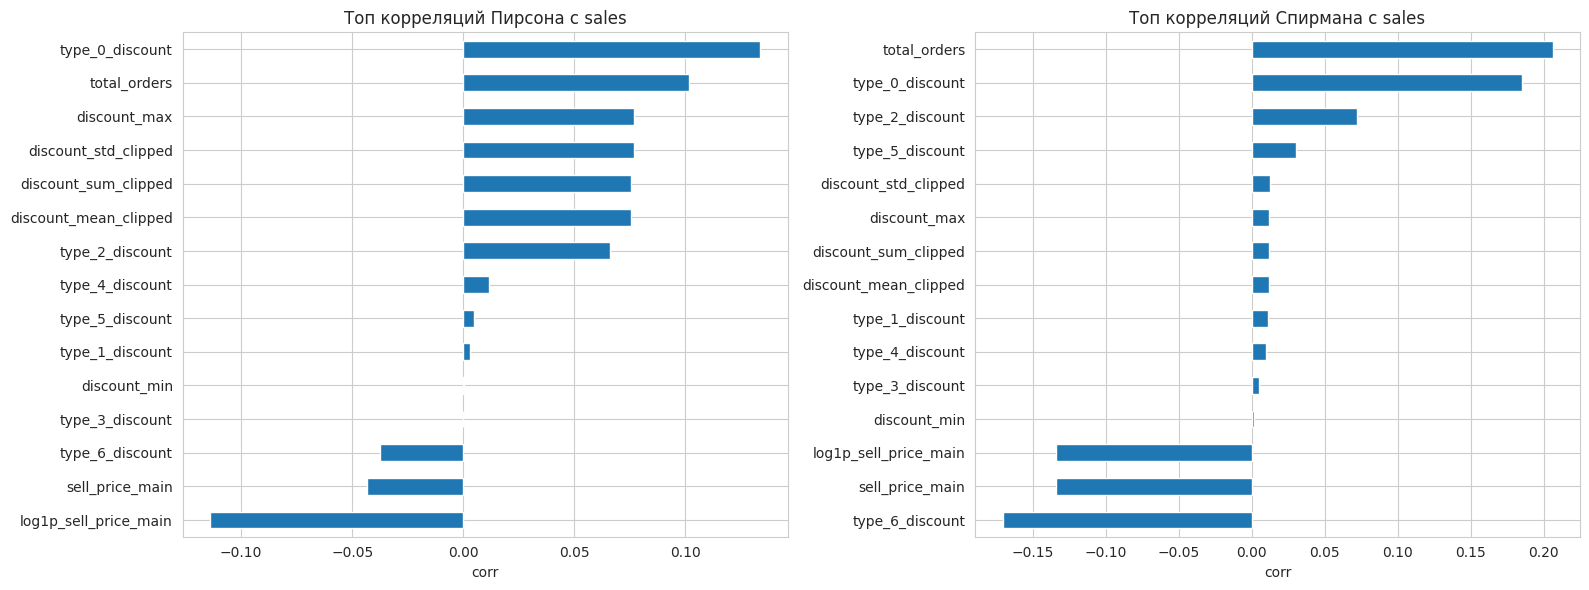

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

corr_pearson = eda[numeric + ["sales"]].corr(numeric_only=True)["sales"].drop("sales").sort_values()
corr_spearman = eda[numeric + ["sales"]].corr(method="spearman", numeric_only=True)["sales"].drop("sales").sort_values()

corr_pearson.plot(kind="barh", ax=axes[0])
axes[0].set_title("Топ корреляций Пирсона с sales")
axes[0].set_xlabel("corr")

corr_spearman.plot(kind="barh", ax=axes[1])
axes[1].set_title("Топ корреляций Спирмана с sales")
axes[1].set_xlabel("corr")

plt.tight_layout()
plt.show()


### Анализ активности скидок и суммарной скидки

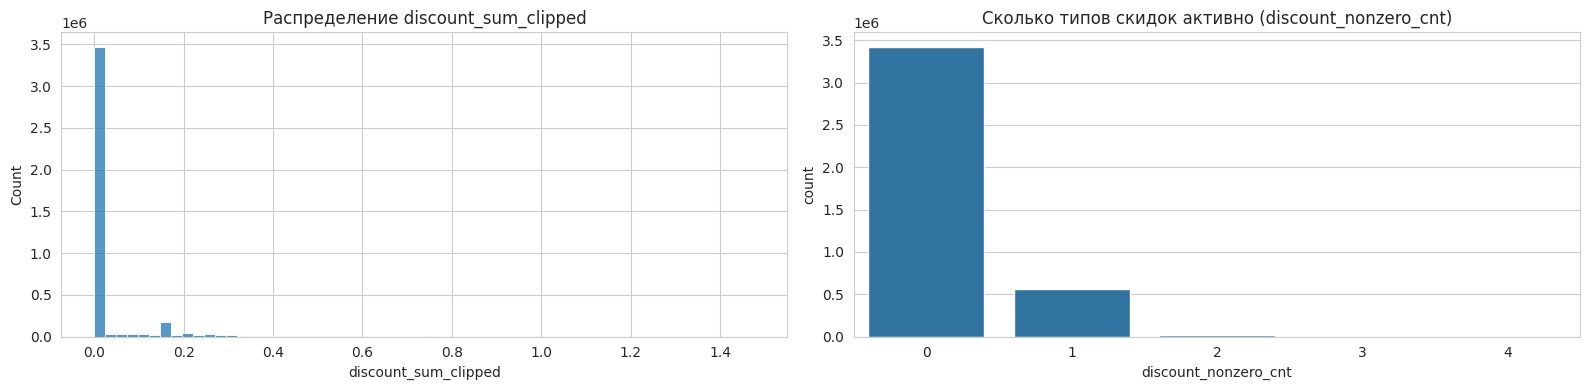

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

sns.histplot(train_clean["discount_sum_clipped"], bins=60, ax=axes[0])
axes[0].set_title("Распределение discount_sum_clipped")

sns.countplot(x=train_clean["discount_nonzero_cnt"], ax=axes[1])
axes[1].set_title("Сколько типов скидок активно (discount_nonzero_cnt)")

plt.tight_layout()
plt.show()


### Корреляции признаков между собой


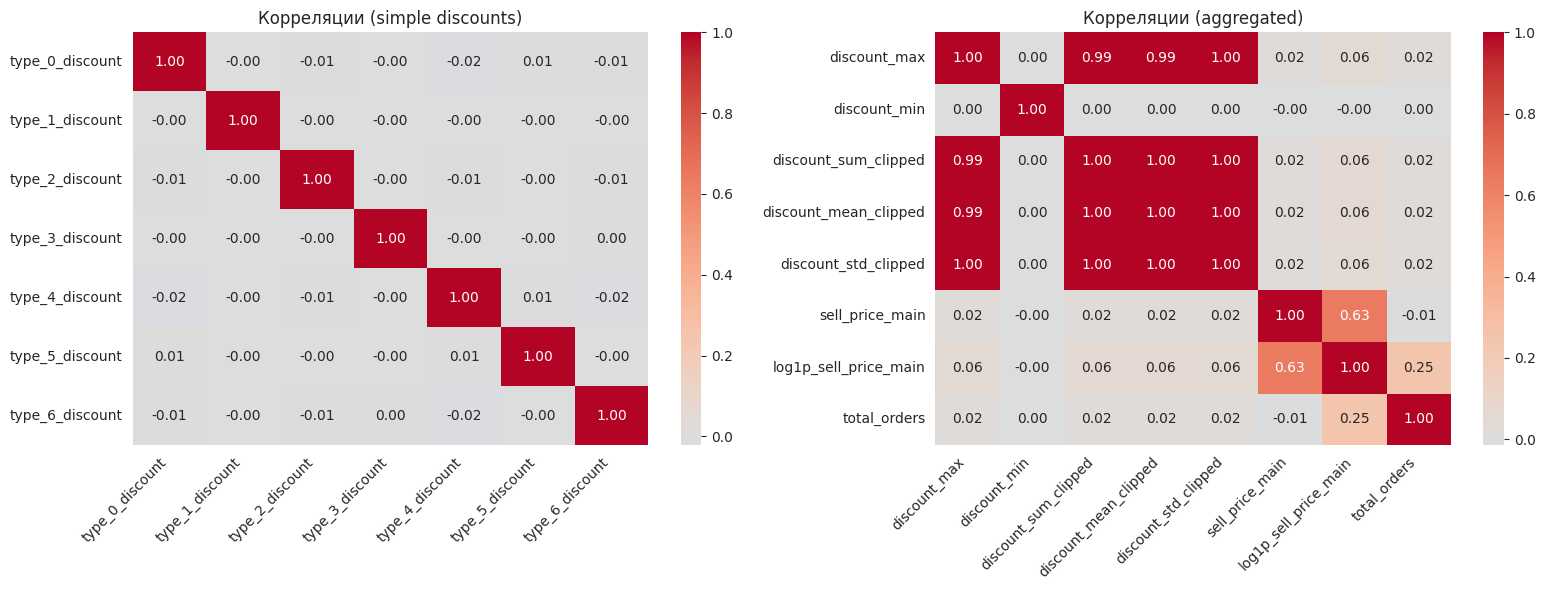

In [16]:
simple_discounts = [
    'type_0_discount',
    'type_1_discount',
    'type_2_discount', 
    'type_3_discount', 
    'type_4_discount', 
    'type_5_discount', 
    'type_6_discount'
]
aggregated = [
    'discount_max', 
    'discount_min', 
    'discount_sum_clipped', 
    'discount_mean_clipped', 
    'discount_std_clipped',
    'sell_price_main',
    'log1p_sell_price_main',
    'total_orders',
]
corr_simple = train_clean[simple_discounts].corr(numeric_only=True)
corr_agg = train_clean[aggregated].corr(numeric_only=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(corr_simple, annot=True, fmt=".2f", cmap="coolwarm", center=0, ax=axes[0])
axes[0].set_title("Корреляции (simple discounts)")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

sns.heatmap(corr_agg, annot=True, fmt=".2f", cmap="coolwarm", center=0, ax=axes[1])
axes[1].set_title("Корреляции (aggregated)")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


### Связь категориальных признаков

In [17]:
# mean(sales) по складам + размер групп
wh_stats = (
    train_clean.groupby("warehouse", observed=True)
    .agg(mean_sales=("sales", "mean"), rows=("sales", "size"))
    .sort_values("mean_sales", ascending=False)
)

wh_stats

,mean_sales,rows
warehouse,,
Brno_1,165.8146,643637
Prague_1,146.6351,780566
Budapest_1,102.9342,574582
Munich_1,99.5199,259287
Prague_3,78.3149,779655
Prague_2,75.2007,770709
Frankfurt_1,46.1161,198931


In [18]:
l1_stats = (
    train_clean.groupby("L1_category_name_en", observed=True)
    .agg(mean_sales=("sales", "mean"), rows=("sales", "size"))
    .sort_values("mean_sales", ascending=False)
)

l1_stats

,mean_sales,rows
L1_category_name_en,,
Bakery,121.7700,1492850
Fruit and vegetable,114.4253,2023667
Meat and fish,42.7390,490850


# Валидация time-split
- В соревновании test — это **следующие 14 дней** после конца train
- Поэтому используем — **out-of-time holdout**: последние 14 дней train.


In [19]:
from rohlik.data import time_holdout_split
from rohlik.submission import make_competition_id

train_part, val_part, split_info = time_holdout_split(train_clean, horizon_days=cfg.horizon_days)

val_ids = make_competition_id(val_part[["unique_id", "date"]])
val_meta = val_part[["unique_id", "date", "sales", "weight"]].copy()
val_meta["id"] = val_ids

pred_files = {
    "baseline": Path("submissions/pred_last14_baseline.csv"),
    "lgbm": Path("submissions/pred_last14_lgbm.csv"),
    "lama_1": Path("submissions/pred_last14_lama_1.csv"),
    "lama_2": Path("submissions/pred_last14_lama_2.csv"),
}

rows = []
for name, path in pred_files.items():
    pred_df = pd.read_csv(path)
    merged = val_meta.merge(pred_df, on="id", how="left")
    score = wmae(
        y_true=merged["sales"].to_numpy(),
        y_pred=merged["sales_hat"].to_numpy(),
        weight=merged["weight"].to_numpy(),
    )
    rows.append({"model": name, "wmae": float(score)})

score_table = pd.DataFrame(rows).sort_values("wmae")
score_table


,model,wmae
1,lgbm,19.5840
2,lama_1,20.3457
0,baseline,33.2472
3,lama_2,70.7542
